In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import torch
from gpytorch import kernels

from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [2]:
data = np.loadtxt("/home/max/Software/potential-bassoon/data/data.txt")

In [3]:
np.random.shuffle(data)
# 20k seems to be the limit for OOM
sub_data = data[:20000]
# sub_data = data

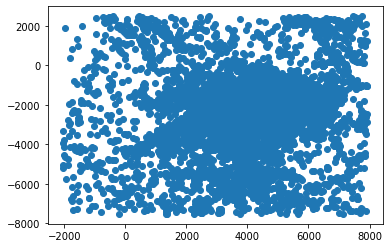

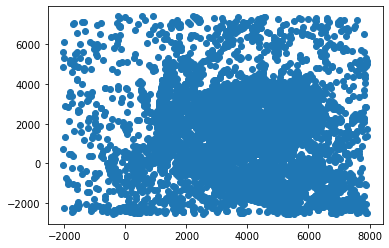

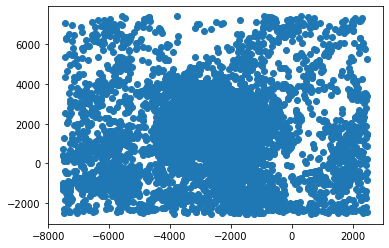

In [4]:
plt.scatter(sub_data.T[0], sub_data.T[1])
plt.show()
plt.scatter(sub_data.T[0], sub_data.T[2])
plt.show()
plt.scatter(sub_data.T[1], sub_data.T[2])
plt.show()

In [6]:
# norm everything
X = sub_data
print(X.shape, X.max(), X.min(), X.mean())
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X.shape, X.max(), X.min(), X.mean())

# only use spatial points for kernel
if True:
    torch_subdata = torch.tensor(X[:, [0, 1, 2]])
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_subdata) 
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:
    z_vals = RBF(1.).__call__(X[:, [0, 1, 2]])[0]


X = np.array([*X.T, z_vals]).T
print(X.shape, X.max(), X.min(), X.mean())

(20000, 7) 7947.5087890625 -7512.6328125 444.29072695098944
(20000, 7) 49.11531080334424 -4.166681560731254 5.960946022501697e-17
(20000, 8) 49.11531080334424 -4.166681560731254 0.2599302097116247


<IPython.core.display.Javascript object>


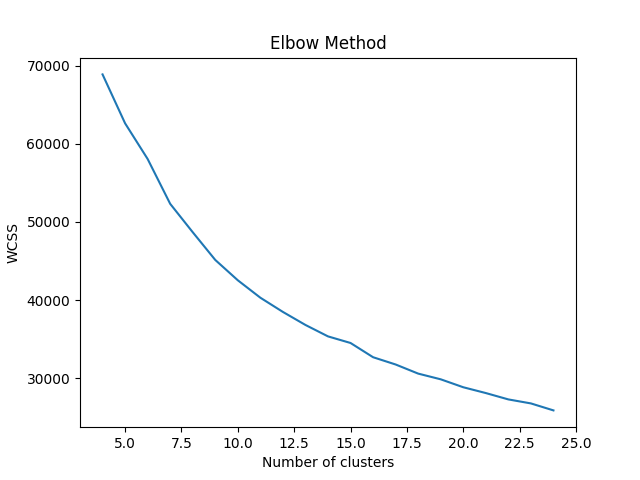

In [200]:
max_cluster = 25
wcss = []
for i in range(4, max_cluster):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(4, max_cluster), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<IPython.core.display.Javascript object>


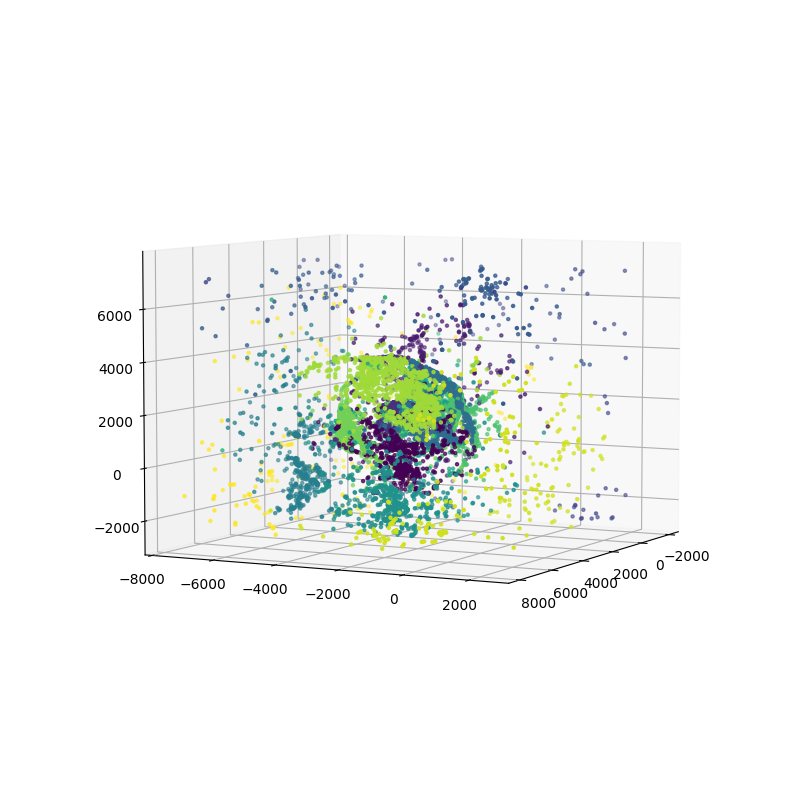

In [202]:
kmeans = KMeans(n_clusters=15, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y1 = kmeans.fit_predict(X)

# plt.scatter(sub_data.T[0], sub_data.T[1], c=pred_y1)
# plt.show()
# plt.scatter(sub_data.T[0], sub_data.T[2], c=pred_y1)
# plt.show()
# plt.scatter(sub_data.T[1], sub_data.T[2], c=pred_y1)
# plt.show()

%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
# ax.scatter(sub_data.T[0], sub_data.T[1], sub_data.T[2])
ax.scatter(sub_data.T[0], sub_data.T[1], sub_data.T[2], c=pred_y1, marker=".")
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10] [2686 2446 1937  983 1548 1065 1230  335 3827 1229 2714]


<IPython.core.display.Javascript object>


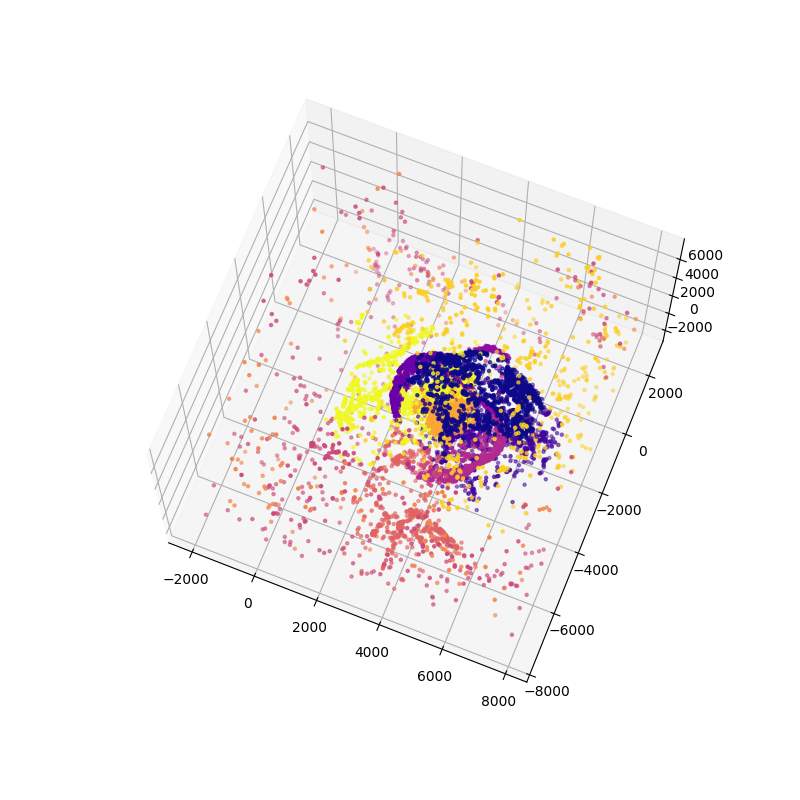

1.0553178711572815 -22.778714042581573 -21.58469468313088


<IPython.core.display.Javascript object>


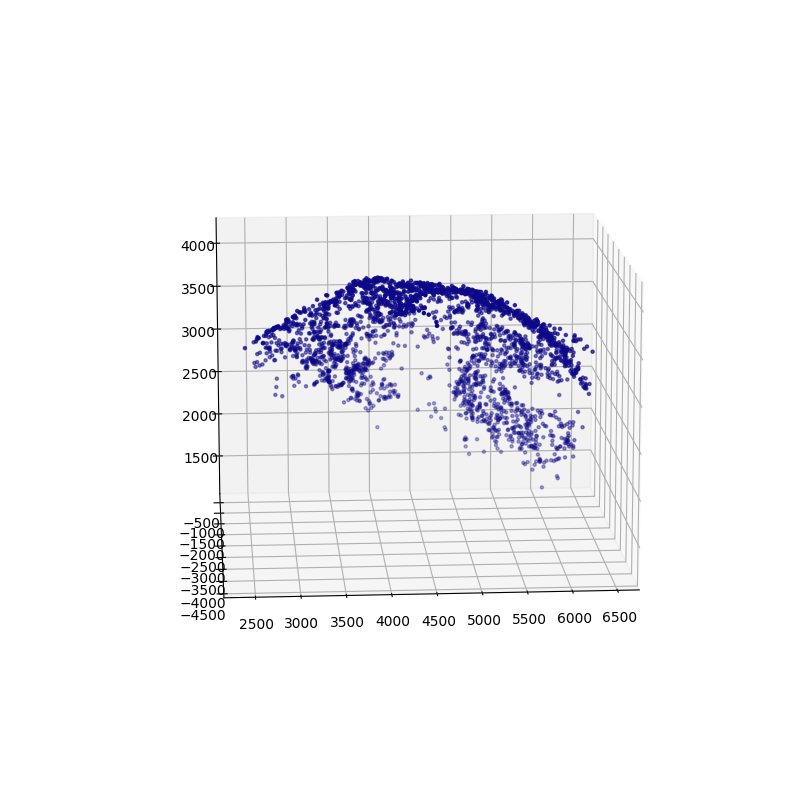

1.02173468920749 -28.065333309011773 -27.46831795520292


<IPython.core.display.Javascript object>


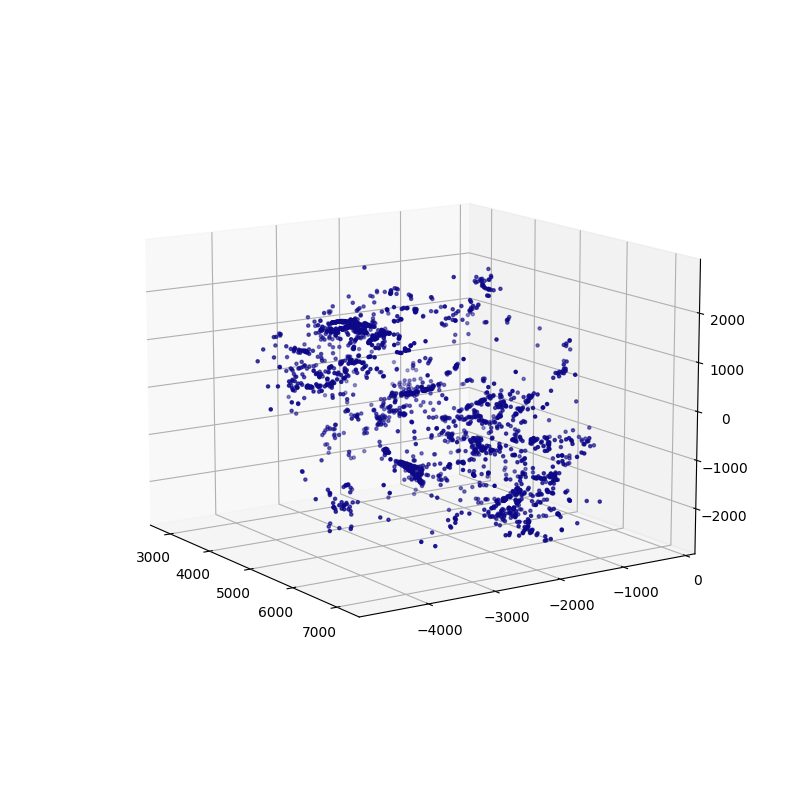

1.0712298565853045 -19.892002652113344 -18.56931314024601


<IPython.core.display.Javascript object>


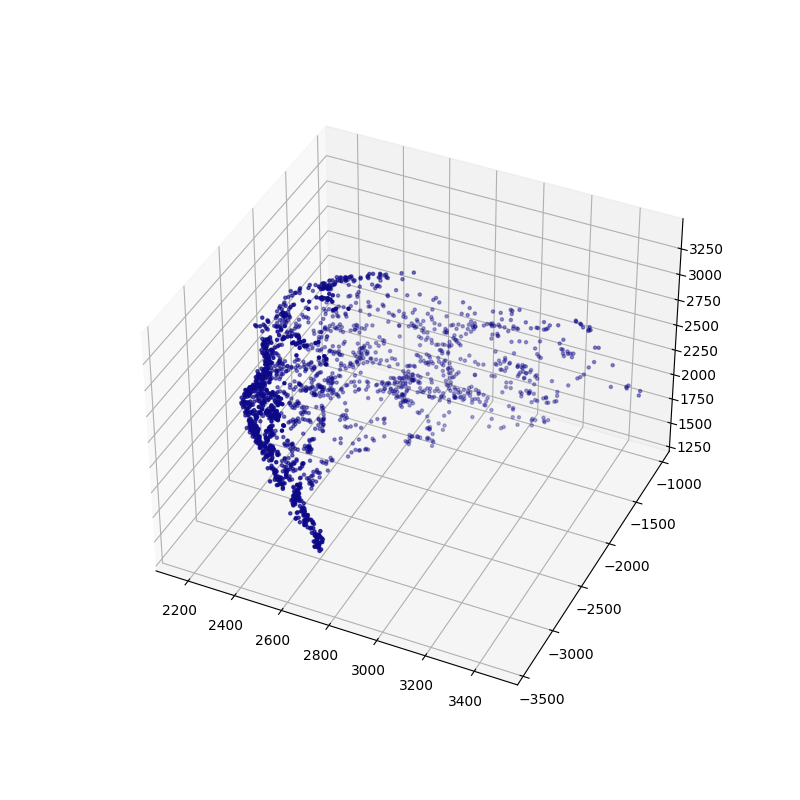

1.1050819322573222 -20.745387350559906 -18.772714262175874


<IPython.core.display.Javascript object>


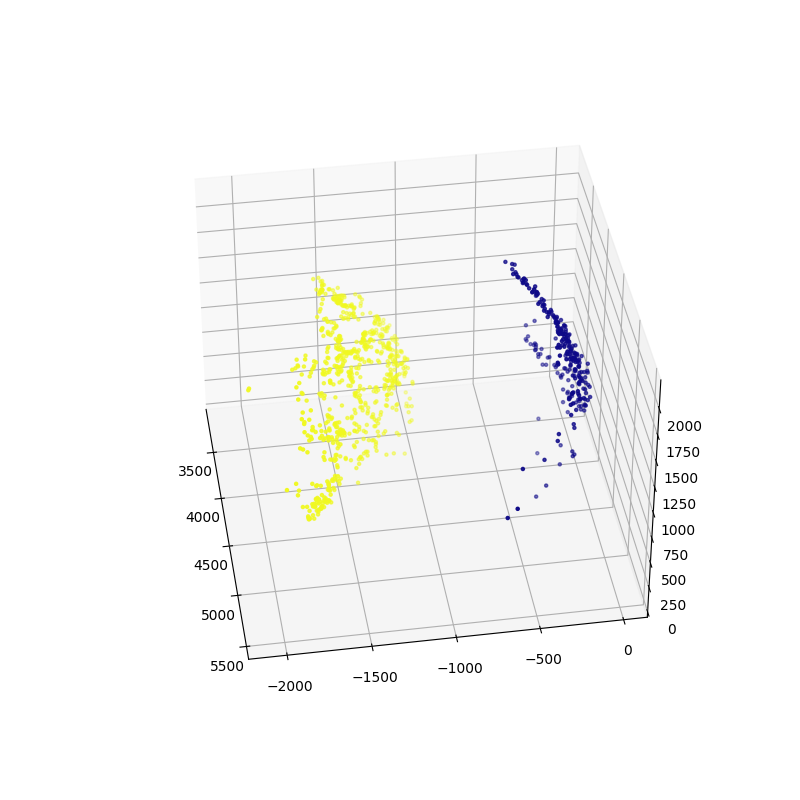

1.0676822486111728 -21.81063385471462 -20.42801955646037


<IPython.core.display.Javascript object>


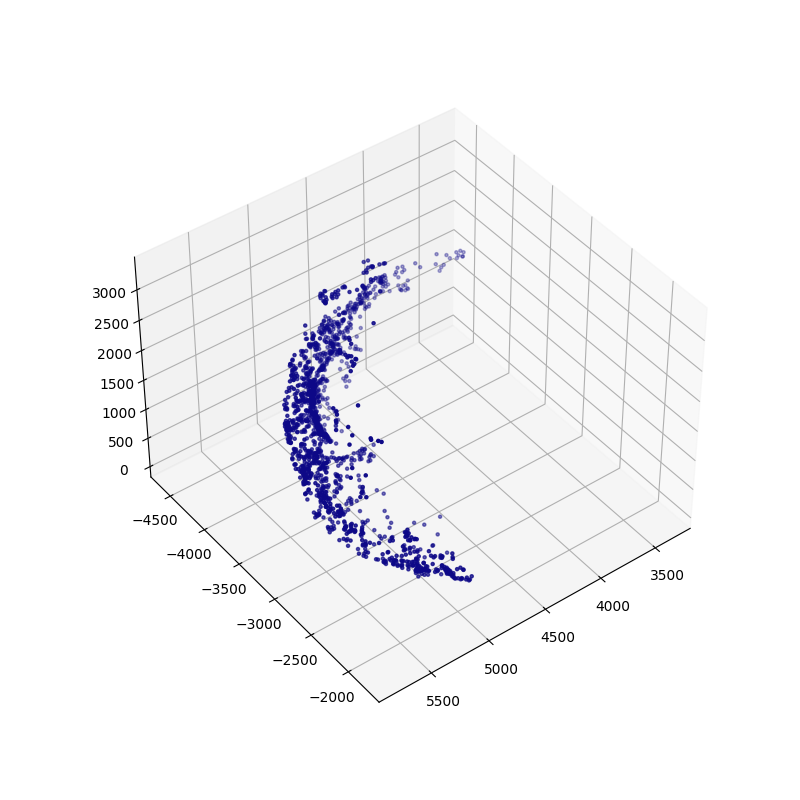

1.0094517386481638 -34.565573102360545 -34.24192735419924


<IPython.core.display.Javascript object>


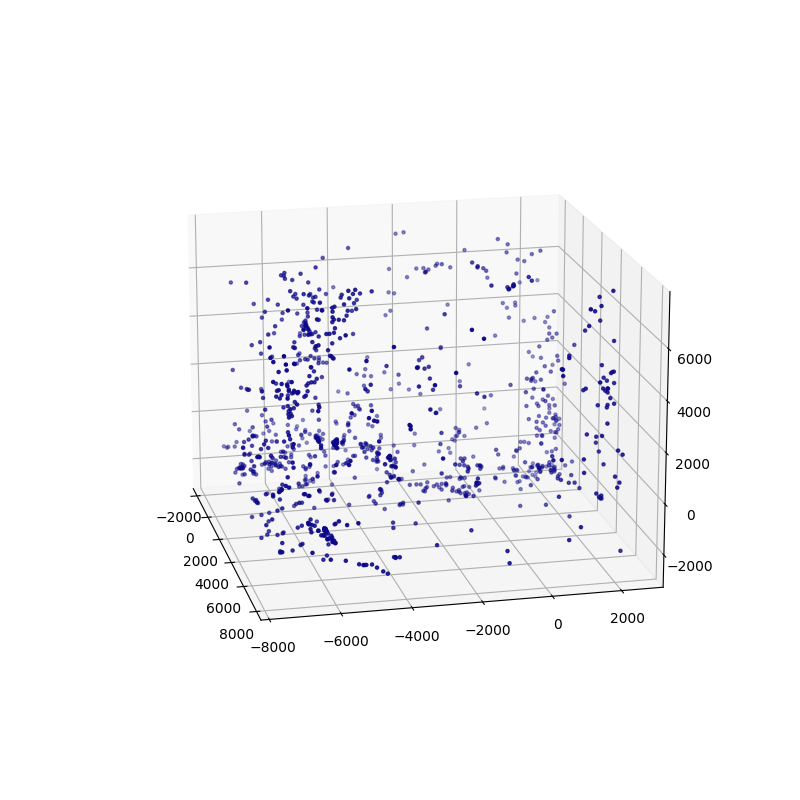

1.0249379942816588 -28.290393687504896 -27.602053827005005


<IPython.core.display.Javascript object>


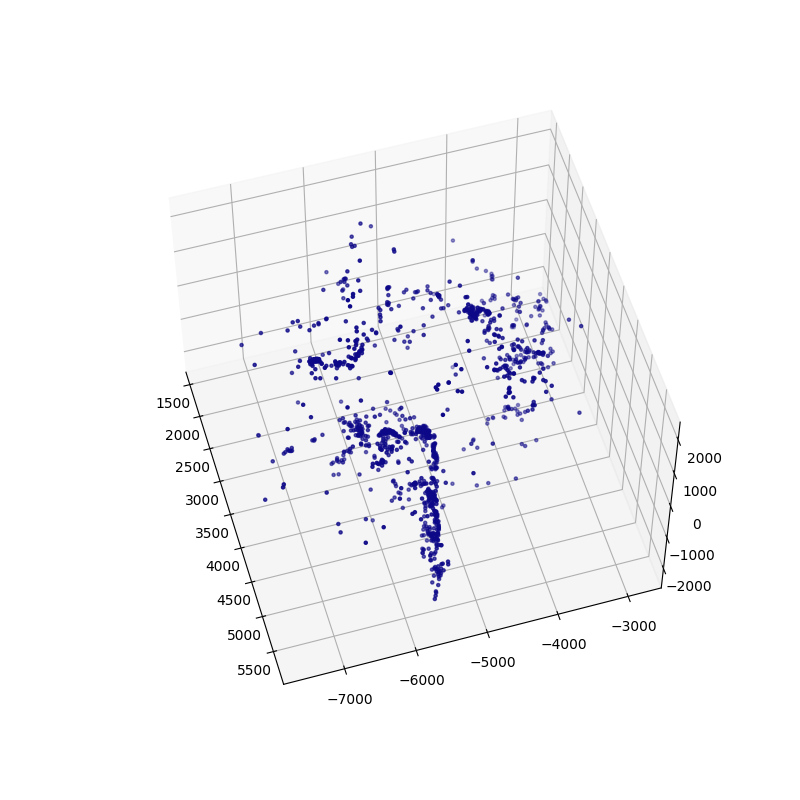

1.0179265428782502 -38.45437705934178 -37.77716312476699


<IPython.core.display.Javascript object>


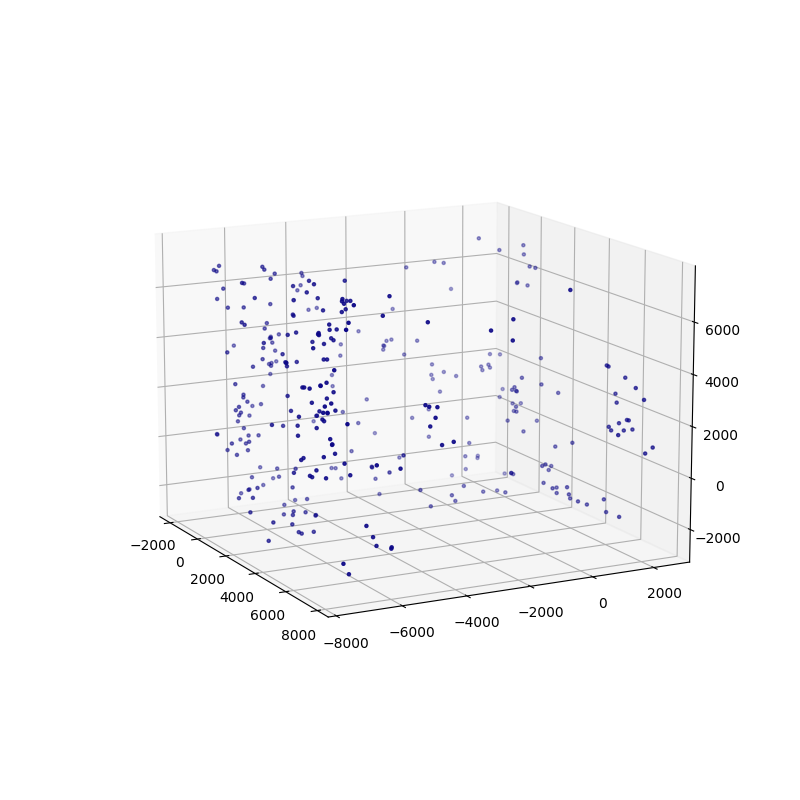

1.057628556830644 -20.011479521559192 -18.921084715721786


<IPython.core.display.Javascript object>


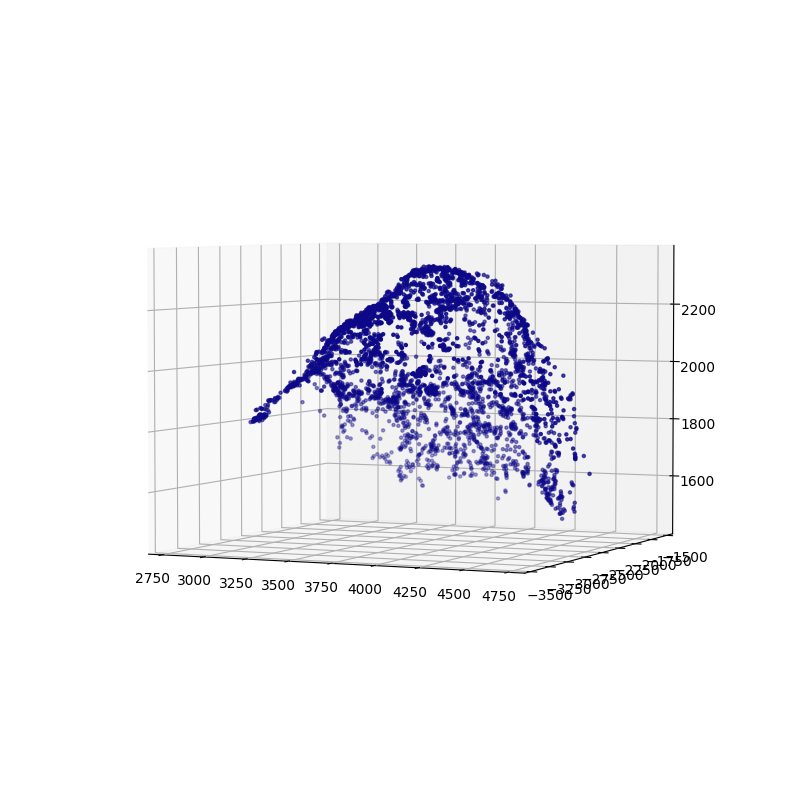

1.0124576543357595 -31.28939026736163 -30.904394009337192


<IPython.core.display.Javascript object>


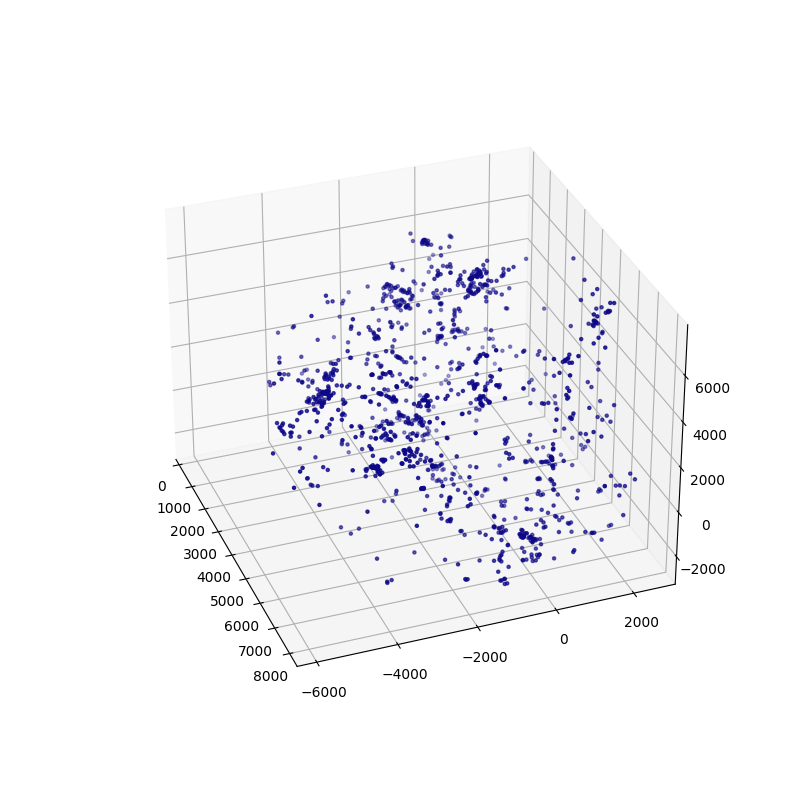

1.024921514615739 -26.906322595509387 -26.252080975777968


<IPython.core.display.Javascript object>


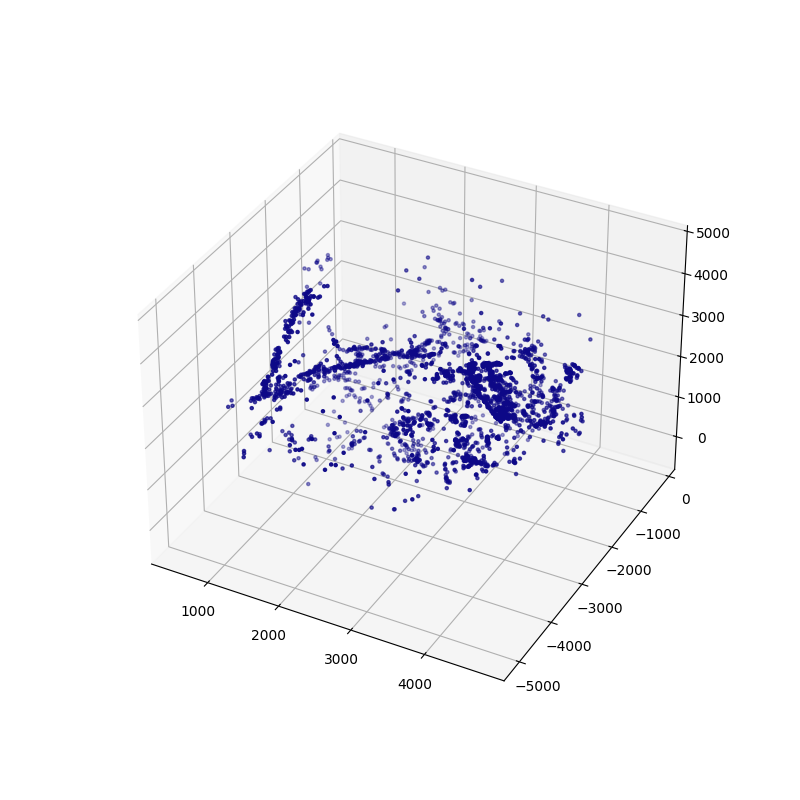

In [24]:
model = GaussianMixture(n_components=11)
model.fit(X)
pred_y1 = model.predict(X)

values, counts = np.unique(pred_y1, return_counts=True)
print(values, counts)

%matplotlib notebook

plot_dat = np.array([sub_data.T[0], sub_data.T[1], sub_data.T[2], pred_y1]).T[:10000]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_dat.T[3], marker=".", cmap="plasma")
plt.show()



for val in values:
    plot_dat = sub_data[pred_y1 == val]
    plot_y = pred_y1[pred_y1 == val]
    
    model = GaussianMixture(n_components=1)
    model.fit(plot_dat)
    m1 = model.lower_bound_
    
    model = GaussianMixture(n_components=2)
    model.fit(plot_dat)
    m2 = model.lower_bound_

    print(m1 / m2, m1, m2)
    
    if (m1 / m2) < 1.08:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_y, marker=".", cmap="plasma")
        plt.show()
    else:
        
        plot_pred_y = model.predict(plot_dat)
        
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_dat.T[0], plot_dat.T[1], plot_dat.T[2], c=plot_pred_y, marker=".", cmap="plasma")
        plt.show()
        
    

1 -11.91067462973206
2 -6.550913480598229
3 -5.411757094855483
4 -4.393595481645407
5 -4.300611338771785
6 -3.3646641097597234
7 -3.341090420282354
8 -2.765766671015237
9 -2.1259537261117405
10 -3.0322686808966273
11 -2.312786983347134
12 -2.092712994699739
13 -1.9323831707579822
14 -1.543977915608442
15 -1.5364975158955534
16 -1.5067903903041358
17 -1.2341296267339854
18 -1.1335374254148025
19 -0.8368329767988778
20 -1.0624042086599528
21 -0.8932890788963014
22 -0.5852608971740592
23 -0.6589543139491437
24 -0.23054741417312194


<IPython.core.display.Javascript object>


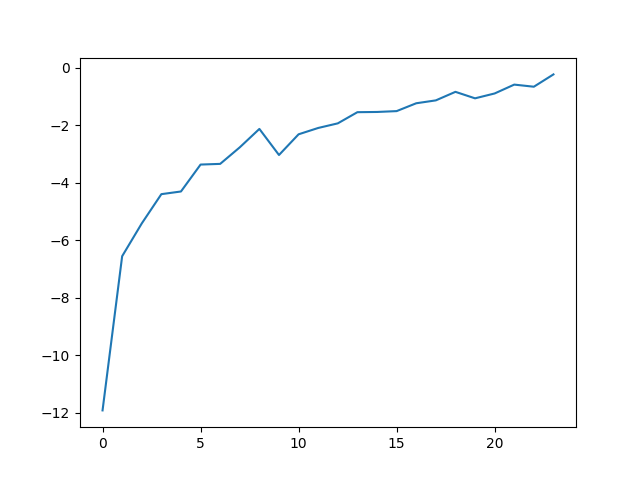

In [19]:
elbos = []
for i in range(1, 25):
    model = GaussianMixture(n_components=i)
    model.fit(X)
    elbos.append(model.lower_bound_)
    print(i, model.lower_bound_)
    
plt.plot(elbos)
plt.show()    

# Fun with kernels - general

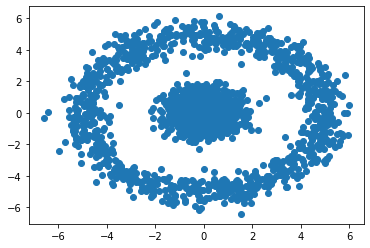

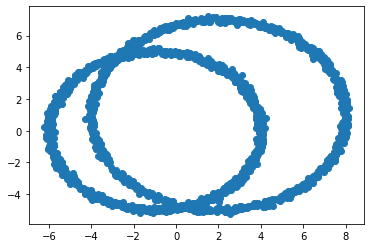

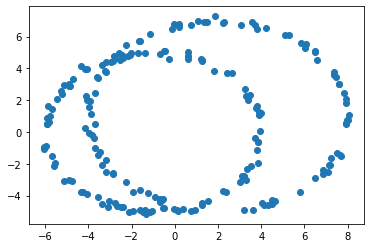

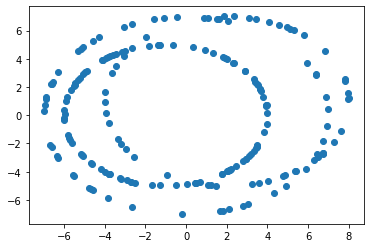

In [2]:
# Create test datasets

def make_ring(
    n_sample: int = 1000,
    radius: float = 1.,
    rad_spread: float = 0.1,
    center: np.array = np.zeros(2),
    return_as_polar: bool = False
):
    raw_norm = np.random.randn(n_sample)
    raw_uni = np.random.rand(n_sample)
    
    r = raw_norm * rad_spread + radius
    phi = raw_uni * 2 * np.pi
    
    if return_as_polar:
        x = r
        y = phi
    else:
        x = r * np.cos(phi) - center[0]
        y = r * np.sin(phi) - center[1]
        
    return np.array([x, y]).T

ring1 = make_ring(radius=5., rad_spread=0.5)
ring2 = make_ring(radius=1., rad_spread=0.5)

rings_1  = np.concatenate([ring1, ring2])
plt.scatter(rings_1.T[0], rings_1.T[1])
plt.show()

ring1 = make_ring(radius=5., rad_spread=0.1, center=np.array([1., 0.]))
ring2 = make_ring(radius=6., rad_spread=0.1, center=np.array([-2., -1.]))
ring3 = make_ring(radius=7., rad_spread=0.1)

rings_2  = np.concatenate([ring1, ring2])
plt.scatter(rings_2.T[0], rings_2.T[1])
plt.show()

ring1 = make_ring(n_sample=100, radius=5., rad_spread=0.1, center=np.array([1., 0.]))
ring2 = make_ring(n_sample=100, radius=6., rad_spread=0.1, center=np.array([-2., -1.]))

rings_3  = np.concatenate([ring1, ring2])
plt.scatter(rings_3.T[0], rings_3.T[1])
plt.show()

ring1 = make_ring(n_sample=100, radius=5., rad_spread=0.01, center=np.array([1., 0.]))
ring2 = make_ring(n_sample=50, radius=6., rad_spread=0.01, center=np.array([-2., -1.]))
ring3 = make_ring(n_sample=50, radius=7., rad_spread=0.01)

rings_4  = np.concatenate([ring1, ring2, ring3])
plt.scatter(rings_4.T[0], rings_4.T[1])
plt.show()

In [3]:
torch_rings_1 = torch.tensor(rings_1)
torch_rings_2 = torch.tensor(rings_2)
torch_rings_3 = torch.tensor(rings_3)
torch_rings_3 = torch.tensor(rings_4)

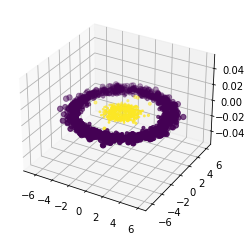

/home/max/.local/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


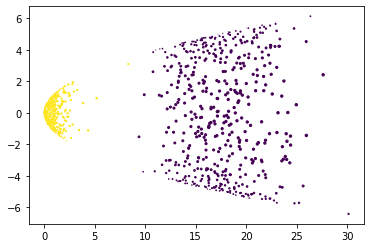

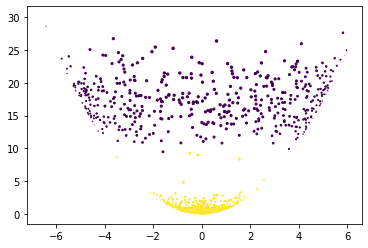

In [4]:
covar_module = kernels.LinearKernel()
# covar_module.lengthscale = torch.tensor(0.0001)
lazy_covar_matrix = covar_module(torch_rings_1) # Returns a RootLazyTensor
# tensor_covar_matrix = lazy_covar_matrix.evaluate() # Gets the actual tensor for this kernel matrix
z_vals = lazy_covar_matrix.diag().detach().numpy()


X = np.array([rings_1.T[0], rings_1.T[1], z_vals]).T
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y1 = kmeans.fit_predict(X)



fig = plt.figure()
ax = fig.add_subplot(projection='3d')
plt.scatter(rings_1.T[0], rings_1.T[1], z_vals, c=pred_y1)
plt.show()
plt.scatter(z_vals, rings_1.T[1], rings_1.T[0], c=pred_y1)
plt.show()
plt.scatter(rings_1.T[0], z_vals, rings_1.T[1], c=pred_y1)
plt.show()

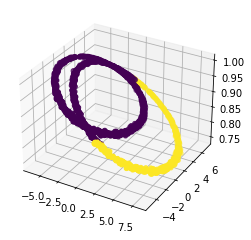

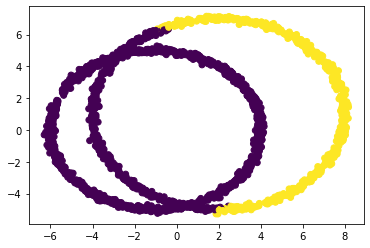

In [600]:
X = rings_2
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

if False:
    torch_rings_2 = torch.tensor(X)
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_rings_2) # Returns a RootLazyTensor
    # tensor_covar_matrix = lazy_covar_matrix.evaluate() # Gets the actual tensor for this kernel matrix
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:    
    z_vals = RBF(4.5).__call__(X)[0]

X = np.array([*X.T, z_vals]).T
if False:
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y2 = kmeans.fit_predict(X)
else:
    model = GaussianMixture(n_components=2)
    model.fit(X)
    pred_y2 = model.predict(X)

# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(rings_2.T[0], rings_2.T[1], z_vals, c=pred_y2)
plt.show()

fig = plt.figure()
plt.scatter(rings_2.T[0], rings_2.T[1], c=pred_y2)
plt.show()

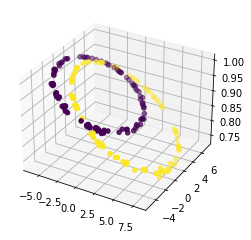

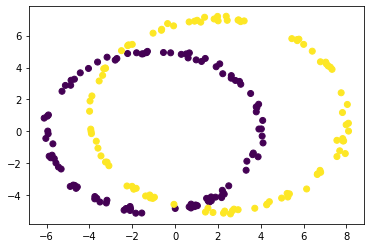

In [613]:
X = rings_3
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

if False:
    torch_rings_3 = torch.tensor(X)
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_rings_3) # Returns a RootLazyTensor
    # tensor_covar_matrix = lazy_covar_matrix.evaluate() # Gets the actual tensor for this kernel matrix
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:    
    z_vals = RBF(4.5).__call__(X)[0]

X = np.array([*X.T, z_vals]).T
if False:
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y3 = kmeans.fit_predict(X)
else:
    model = GaussianMixture(n_components=2)
    model.fit(X)
    pred_y3 = model.predict(X)

# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(rings_3.T[0], rings_3.T[1], z_vals, c=pred_y3)
plt.show()

fig = plt.figure()
plt.scatter(rings_3.T[0], rings_3.T[1], c=pred_y3)
plt.show()

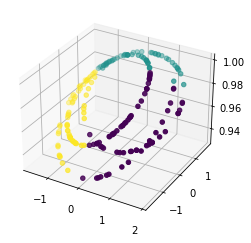

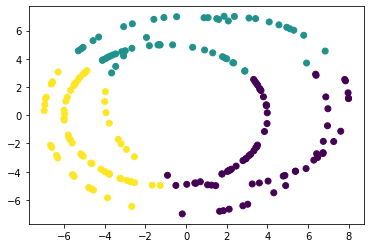

In [5]:
X = rings_4
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

if False:
    torch_rings_4 = torch.tensor(X)
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_rings_4) # Returns a RootLazyTensor
    # tensor_covar_matrix = lazy_covar_matrix.evaluate() # Gets the actual tensor for this kernel matrix
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:    
    z_vals = RBF(7.5).__call__(X)[0]

X = np.array([*X.T, z_vals]).T
if False:
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y3 = kmeans.fit_predict(X)
else:
    model = GaussianMixture(n_components=3)
    model.fit(X)
    pred_y3 = model.predict(X)

# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T, c=pred_y3)
plt.show()

fig = plt.figure()
plt.scatter(rings_4.T[0], rings_4.T[1], c=pred_y3)
plt.show()

(array([ 1.00327079, 52.24711056,  1.00323193,  1.00320986, 27.858516  ,
        1.00316139, 24.71860709,  1.0031027 , 10.04629719,  1.0030358 ,
       30.84787331, 20.78331045, 40.47927292,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ]), array([2.00046729e+02, 1.48799619e+02, 1.48796387e+02, 1.48793177e+02,
       1.21934661e+02, 1.21931499e+02, 9.82128924e+01, 9.82097897e+01,
       8.91634925e+01, 8.91604567e+01, 5.93125834e+01, 3.95292729e+01,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02,
       5.00000000e-02, 5.00000000e-02, 5.00000000e-02, 5.00000000e-02]))


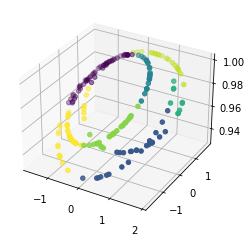

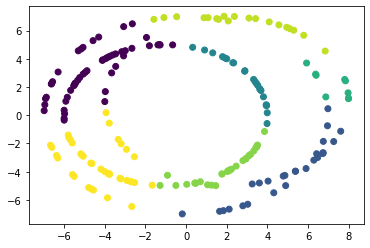

In [10]:
from sklearn.mixture import BayesianGaussianMixture







X = rings_4
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

if False:
    torch_rings_4 = torch.tensor(X)
    covar_module = kernels.LinearKernel()
    lazy_covar_matrix = covar_module(torch_rings_4) # Returns a RootLazyTensor
    # tensor_covar_matrix = lazy_covar_matrix.evaluate() # Gets the actual tensor for this kernel matrix
    z_vals = lazy_covar_matrix.diag().detach().numpy()
else:    
    z_vals = RBF(7.5).__call__(X)[0]

X = np.array([*X.T, z_vals]).T
if False:
    kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y3 = kmeans.fit_predict(X)
else:
    bgm = BayesianGaussianMixture(n_components=20, random_state=42).fit(X)
    pred_y3 = bgm.predict(X)
    
    print(bgm.weight_concentration_)

# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T, c=pred_y3)
plt.show()

fig = plt.figure()
plt.scatter(rings_4.T[0], rings_4.T[1], c=pred_y3)
plt.show()



